In [152]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import pycaret
from pycaret.regression import *

In [125]:
df = pd.read_csv('AmesHousing.csv')
data = df.drop(['PID'], axis=1)
data =data.fillna(0)


In [126]:
data = data.rename(columns={"MS SubClass": "MSSubClass", "MS Zoning": "MSZoning",'Lot Frontage':'LotFrontage', 'Lot Area':'LotArea',
       'Sale Condition':'SaleCondition','Yr Sold':'YrSold','YearBuilt': 'YearBuilt', 'Gr Liv Area': 'GrLivArea', 'Garage Area':'GarageArea',
       'Year Built':'YearBuilt','Pool Area':'PoolArea','Year Remod/Add':'YearRemodAdd','Garage Cars':'GarageCars','Total Bsmt SF':"TotalBsmtSF",
       "Full Bath":"FullBath","Mas Vnr Area":"MasVnrArea","1st Flr SF":"FstFlrSF","Garage Yr Blt":"GarageYrBlt","TotRms AbvGrd":"TotRmsAbvGrd",
       "Overall Qual":"OverallQual","Screen Porch":"ScreenPorch","Open Porch SF":"OpenPorchSF","Enclosed Porch":"EnclosedPorch",
       "Wood Deck SF":"WoodDeckSF","2nd Flr SF":"SndFlrSF","Bedroom AbvGr":"BedroomAbvGr","Kitchen AbvGr":"KitchenAbvGr",
})


Data cleaning

In [127]:
# create dummies
data['Fence'] = data['Fence'].notna()
data['Pool'] = data['PoolArea'] > 0


# Delete all data with MSZoning = commercial, agriculture and industrial as these are not residential units
data = data[(data.MSZoning != 'C (all)') & (data.MSZoning != 'I (all)') & (data.MSZoning != 'A (agr)')]

# Delete abnormal sales
data = data[(data.SaleCondition != 'Abnorml')] 
data = data[(data.SaleCondition != 'Family')] 

In [128]:
columns_to_keep=["YearBuilt","YearRemodAdd","Pool","Fence","ScreenPorch","OpenPorchSF","EnclosedPorch",
"WoodDeckSF","GarageArea","LotArea","TotalBsmtSF","FstFlrSF","SndFlrSF","GrLivArea","FullBath","BedroomAbvGr",
"KitchenAbvGr","TotRmsAbvGrd","Fireplaces","GarageCars","LotFrontage",'SalePrice']

In [129]:
# Select Features
data = data[columns_to_keep]

X = data.drop('SalePrice', axis=1)
Y = data[['SalePrice']]

In [130]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=.3, random_state=1121218)

In [131]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

In [132]:
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(data[numerical_features])
data[numerical_features] = imputer.transform(data[numerical_features])

In [133]:
sclaer = MinMaxScaler()
sclaer = sclaer.fit(data[numerical_features])
data[numerical_features] = sclaer.transform(data[numerical_features])

In [134]:

labelencoder = LabelEncoder()

data['Fence'] = labelencoder.fit_transform(data['Fence'])
data['Pool'] = labelencoder.fit_transform(data['Pool'])


In [135]:
reg = setup(data = data, target = 'SalePrice')

,Description,Value
0,session_id,5205
1,Target,SalePrice
2,Original Data,"(2676, 22)"
3,Missing Values,False
4,Numeric Features,19
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1873, 21)"


In [136]:
rfr = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,18689.0796,1231203986.1175,35088.5164,0.8008,0.1573,0.1087
1,17564.4205,826890030.2458,28755.6956,0.8558,0.1358,0.0999
2,16398.0363,604051536.0614,24577.4599,0.8792,0.1279,0.0947
3,18103.1510,741230055.0342,27225.5405,0.8845,0.1430,0.1013
4,17955.5247,927800140.9491,30459.8119,0.8774,0.1316,0.0931
5,16792.0041,557648635.7590,23614.5852,0.8781,0.1235,0.0967
6,19919.6973,987663385.5969,31427.1123,0.8298,0.1516,0.1116
7,19697.7808,1173070003.9160,34250.1095,0.8566,0.1296,0.0939
8,16103.2510,585080775.5385,24188.4430,0.8909,0.1315,0.0941


In [137]:
tuned_rfr = tune_model(rfr,n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,19148.6617,1161359260.0359,34078.7215,0.8121,0.1602,0.1134
1,18094.3642,828287036.0680,28779.9763,0.8556,0.1385,0.1036
2,17658.5004,709869248.1092,26643.3716,0.8581,0.1377,0.1012
3,18359.3581,729899998.0826,27016.6615,0.8862,0.1438,0.1033
4,18524.4695,965319593.9896,31069.5928,0.8725,0.1356,0.0997
5,17066.6124,577154315.0372,24024.0362,0.8738,0.1305,0.1014
6,19550.6589,1064186695.8493,32621.8745,0.8166,0.1520,0.1120
7,20396.2422,1328815752.5961,36452.9252,0.8375,0.1340,0.0981
8,17210.5393,668518034.9963,25855.7157,0.8754,0.1381,0.1021


In [138]:
print(tuned_rfr)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.001,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=290, n_jobs=-1, oob_score=False,
                      random_state=5205, verbose=0, warm_start=False)


In [139]:
_ = tuned_rfr.fit(X_train, y_train)


In [140]:
import pickle
filename = 'last_model.sav'
pickle.dump(tuned_rfr, open(filename, 'wb'))

Evaluation du modele

In [150]:
def evaluate_Regression_models(model,x_test,y_test):
  prediction = model.predict(x_test)
  print("Mean Absolute Error:",
                       mean_absolute_error(y_test,prediction))
  print("Mean Squared Error : ", 
                       mean_squared_error(y_test,prediction))
  print("Root Mean Squared Error : ",
                     np.sqrt(mean_squared_error(y_test,prediction)))
  print("R2 Score : ",r2_score(y_test,prediction))

In [141]:
my_model = pickle.load(open("last_model.sav", 'rb'))

In [143]:
predict_on_Xtrain = my_model.predict(X_train)
predict_on_Xvalid = my_model.predict(X_valid)

In [153]:
evaluate_Regression_models(my_model,X_valid,y_valid)

Mean Absolute Error: 18396.09951432452
Mean Squared Error :  796033163.5612109
Root Mean Squared Error :  28214.059678841168
R2 Score :  0.8779291106952891


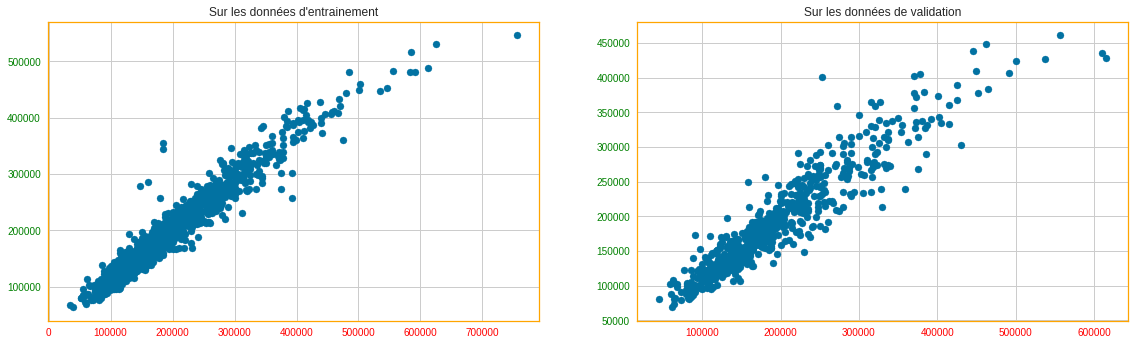

In [154]:
with plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'green', 'figure.facecolor':'white'}):
    fig, (ax1, ax2) = plt.subplots(1,2)
    plt.subplots_adjust(right=2)

    ax1.scatter(y_train,predict_on_Xtrain)
    ax1.set_title("Sur les données d'entrainement")

    ax2.scatter(y_valid,predict_on_Xvalid)
    ax2.set_title("Sur les données de validation")